# Hybrid Recommendation system

In [4]:
import pandas as pd
import numpy as np

## Data Loading

In [5]:
movies = pd.read_csv('ml-25m/movies.csv')
ratings = pd.read_csv('ml-25m/ratings.csv')
tags = pd.read_csv('ml-25m/tags.csv')
print('movies: ', movies.shape)
print('ratings: ', ratings.shape)
print('tags: ', tags.shape)

movies:  (62423, 3)
ratings:  (25000095, 4)
tags:  (1093360, 4)


In [6]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [8]:
tags.head(5)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


# Pre Processing

In [9]:
df = pd.merge(ratings, movies, on='movieId' , how='left')
df = df.drop('title', axis=1)
df.head(5)

,userId,movieId,rating,timestamp,genres
0,1,296,5.0,1147880044,Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Drama
2,1,307,5.0,1147868828,Drama
3,1,665,5.0,1147878820,Comedy|Drama|War
4,1,899,3.5,1147868510,Comedy|Musical|Romance


In [10]:
df['genres'] = df['genres'].str.split('|')

In [11]:
tags['tag'] = tags['tag'].str.split('|')
tags.drop('timestamp', axis=1, inplace=True)

In [12]:
tags = tags.groupby(['userId','movieId'])['tag'].apply(lambda x: ','.join(x.astype(str))).reset_index()
tags.head(5)

,userId,movieId,tag
0,3,260,"['classic'],['sci-fi']"
1,4,1732,"['dark comedy'],['great dialogue']"
2,4,7569,"[""so bad it's good""]"
3,4,44665,['unreliable narrators']
4,4,115569,['tense']


In [13]:
df = pd.merge(df, tags, on=['userId','movieId'], how='left')

In [14]:
df.shape

(25000095, 6)

In [15]:
df['tag'] = df['tag'].apply(lambda d: d if isinstance(d, list) else [])
df['genres'] = df['genres'].apply(lambda d: d if isinstance(d, list) else [])

In [16]:
df.head()

,userId,movieId,rating,timestamp,genres,tag
0,1,296,5.0,1147880044,"[Comedy, Crime, Drama, Thriller]",[]
1,1,306,3.5,1147868817,[Drama],[]
2,1,307,5.0,1147868828,[Drama],[]
3,1,665,5.0,1147878820,"[Comedy, Drama, War]",[]
4,1,899,3.5,1147868510,"[Comedy, Musical, Romance]",[]


#### Split into train and test data

In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df.userId)

In [18]:
train_data = train_data.sort_values(['userId', 'movieId'])
train_data.head()

,userId,movieId,rating,timestamp,genres,tag
0,1,296,5.0,1147880044,"[Comedy, Crime, Drama, Thriller]",[]
1,1,306,3.5,1147868817,[Drama],[]
3,1,665,5.0,1147878820,"[Comedy, Drama, War]",[]
4,1,899,3.5,1147868510,"[Comedy, Musical, Romance]",[]
5,1,1088,4.0,1147868495,"[Drama, Musical, Romance]",[]


In [19]:
test_data = test_data.sort_values(['userId','movieId'])
test_data.head()

,userId,movieId,rating,timestamp,genres,tag
2,1,307,5.0,1147868828,[Drama],[]
7,1,1217,3.5,1147878326,"[Drama, War]",[]
21,1,3448,4.0,1147868480,"[Comedy, Drama, War]",[]
29,1,4973,4.5,1147869080,"[Comedy, Romance]",[]
36,1,5952,4.0,1147868053,"[Adventure, Fantasy]",[]


#### Save the dataframes as csv files

In [20]:
# train_data.to_csv('data/training_data.csv', index = False)
# test_data.to_csv('data/testing_data.csv', index = False)

## Pre-process the movie data

In [21]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].apply(lambda d: d if isinstance(d, list) else [])
movies.head()
# movies.to_csv('data/movies.csv', index = False)

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


# Popularity Model

In [22]:
# Load Data
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ast import literal_eval

train_data = pd.read_csv('data/training_data.csv')
test_data = pd.read_csv('data/testing_data.csv')

In [23]:
movies = pd.read_csv("data/tmdb_5000_movies.csv")

In [24]:
movies.sort_values(by='popularity', ascending=False)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
546,74000000,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",http://www.minionsmovie.com/,211672,"[{""id"": 3487, ""name"": ""assistant""}, {""id"": 179...",en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",875.581305,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-17,1156730962,91.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Before Gru, they had a history of bad bosses",Minions,6.4,4571
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,157336,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,675120017,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mankind was born on Earth. It was never meant ...,Interstellar,8.1,10867
788,58000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.foxmovies.com/movies/deadpool,293660,"[{""id"": 2095, ""name"": ""anti hero""}, {""id"": 307...",en,Deadpool,Deadpool tells the origin story of former Spec...,514.569956,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-09,783112979,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Witness the beginning of a happy ending,Deadpool,7.4,10995
94,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,118340,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,773328629,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,All heroes start somewhere.,Guardians of the Galaxy,7.9,9742
127,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.madmaxmovie.com/,76341,"[{""id"": 2964, ""name"": ""future""}, {""id"": 3713, ...",en,Mad Max: Fury Road,An apocalyptic story set in the furthest reach...,434.278564,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-05-13,378858340,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,What a Lovely Day.,Mad Max: Fury Road,7.2,9427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4625,0,"[{""id"": 27, ""name"": ""Horror""}]",NaN,426067,[],en,Midnight Cabaret,A Broadway producer puts on a play with a Devi...,0.001389,[],[],1990-01-01,0,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The hot spot where Satan's waitin'.,Midnight Cabaret,0.0,0
4118,0,[],NaN,325140,[],en,Hum To Mohabbat Karega,"Raju, a waiter, is in love with the famous TV ...",0.001186,[],[],2000-05-26,0,0.0,[],Released,NaN,Hum To Mohabbat Karega,0.0,0
4727,0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...",NaN,65448,"[{""id"": 378, ""name"": ""prison""}, {""id"": 209476,...",en,Penitentiary,A hitchhiker named Martel Gordone gets in a fi...,0.001117,[],[],1979-12-01,0,99.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"There's only one way out, and 100 fools stand ...",Penitentiary,4.9,8
3361,0,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 28, ""nam...",NaN,77156,[],en,Alien Zone,A man who is having an affair with a married w...,0.000372,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1978-11-22,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""En

In [25]:
genres = {'Adventure': 0,
 'Animation': 1,
 'Children': 2,
 'Comedy': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'Mystery': 11,
 'Sci-Fi': 12,
 'War': 13,
 'Musical': 14,
 'Documentary': 15,
 'IMAX': 16,
 'Western': 17,
 'Film-Noir': 18,
 '(no genres listed)': 19}

In [26]:
def genre_based_popularity(genre):
    mask = movies.genres.apply(lambda x: genre in x)
    filtered_movie = movies[mask]
    filtered_movie = filtered_movie.sort_values(by='popularity', ascending=False)
    return filtered_movie

In [27]:
genre_based_popularity('Animation')[['title', 'popularity']].head(25)

,title,popularity
546,Minions,875.581305
88,Big Hero 6,203.734590
124,Frozen,165.125366
506,Despicable Me 2,136.886704
77,Inside Out,128.655964
55,Brave,125.114374
2294,Spirited Away,118.968562
614,Despicable Me,113.858273
231,"Monsters, Inc.",106.815545
160,How to Train Your Dragon 2,100.213910


In [28]:
genre_based_popularity('Romance')[['title', 'popularity']].head(25)

,title,popularity
809,Forrest Gump,138.133331
1337,Twilight,127.084938
81,Maleficent,110.620647
612,The Twilight Saga: Eclipse,107.069763
326,Cinderella,101.187052
25,Titanic,100.025899
172,The Twilight Saga: Breaking Dawn - Part 2,99.687084
1154,Fifty Shades of Grey,98.755657
898,The Twilight Saga: New Moon,94.815867
1695,Aladdin,92.982009


In [29]:
genre_based_popularity('Action')[['title', 'popularity']].head(25)

,title,popularity
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564
28,Jurassic World,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889
82,Dawn of the Planet of the Apes,243.791743
88,Big Hero 6,203.734590
108,Terminator Genisys,202.042635
26,Captain America: Civil War,198.372395
65,The Dark Knight,187.322927


## Calculate the weighted rating

In [30]:
# this is V
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')

# this is R
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')

# this is C
C = vote_averages.mean()
C

5.6529252550489275

In [31]:
m = vote_counts.quantile(0.95)
m

3040.8999999999996

In [32]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [33]:
movies['wr'] = movies.apply(weighted_rating, axis=1)

In [34]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,wr
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,6.883004
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,6.397112
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,6.037883
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,7.112562
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,5.836779


In [35]:
def genre_based_popularity_PT(genre):
    mask = movies.genres.apply(lambda x: genre in x)
    filtered_movie = movies[mask]
    filtered_movie = filtered_movie.sort_values(by='wr', ascending=False)
    return filtered_movie

In [36]:
genre_based_popularity_PT('Animation')[['title', 'wr', 'popularity']].head(10)

,title,wr,popularity
77,Inside Out,7.256609,128.655964
494,The Lion King,7.152037,90.457886
2294,Spirited Away,7.130169,118.968562
57,WALL·E,7.100727,66.390712
88,Big Hero 6,7.088458,203.734590
66,Up,7.071909,92.201962
328,Finding Nemo,6.953823,85.688789
1541,Toy Story,6.950900,73.640445
231,"Monsters, Inc.",6.878463,106.815545
42,Toy Story 3,6.824805,59.995418


In [37]:
genre_based_popularity_PT('Action')[['title', 'wr', 'popularity']].head(25)

,title,wr,popularity
65,The Dark Knight,7.685113,187.322927
96,Inception,7.656878,167.583710
329,The Lord of the Rings: The Return of the King,7.429908,123.630332
262,The Lord of the Rings: The Fellowship of the Ring,7.392365,138.049577
94,Guardians of the Galaxy,7.365448,481.098624
1990,The Empire Strikes Back,7.331672,78.517830
2912,Star Wars,7.330069,126.393695
634,The Matrix,7.328089,104.309993
330,The Lord of the Rings: The Two Towers,7.322066,106.914973
571,Inglourious Basterds,7.178513,72.595961


# Content Based 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [15]:
# Load movies data
movies = pd.read_csv("data/movies.csv", converters={"genres": literal_eval})

In [16]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
62418,209157,We (2018),[Drama]
62419,209159,Window of the Soul (2001),[Documentary]
62420,209163,Bad Poems (2018),"[Comedy, Drama]"
62421,209169,A Girl Thing (2001),[(no genres listed)]


In [1]:
import pandas as pd
import dask.dataframe as dd
from ast import literal_eval

# Function to load data using Dask, apply converters, and return a Pandas DataFrame
def load_and_convert_to_pandas(file_path, columns=None, fraction=1.0, converters=None):
    # Read data using Dask, apply converters if provided
    if converters:
        dask_df = dd.read_csv(file_path, converters=converters)
    else:
        dask_df = dd.read_csv(file_path)
    
    # If columns are specified, select those columns
    if columns:
        dask_df = dask_df[columns]
    
    # If a fraction less than 1.0 is specified, sample the data
    if fraction < 1.0:
        dask_df = dask_df.sample(frac=fraction)
    
    # Convert the Dask DataFrame to a Pandas DataFrame
    pandas_df = dask_df.compute()
    
    return pandas_df

# Example usage
file_path = 'data/training_data.csv'
columns = ['userId', 'movieId', 'rating']
fraction = 0.01
converters = {"genres": literal_eval, "tag": literal_eval}  # Converters for parsing columns

# Load the data and get a Pandas DataFrame
ratings_train = load_and_convert_to_pandas(file_path, columns, fraction, converters)

# Now you can use train_df as a regular Pandas DataFrame
print(ratings_train.head())


        userId  movieId  rating
946304    7985     2100     4.0
912886    7685     5218     3.5
761197    6395      296     4.0
7270        72       95     2.0
666447    5615    55205     3.0


In [17]:
print(movies.columns)
print(ratings_train.columns)


Index(['movieId', 'title', 'genres'], dtype='object')
Index(['userId', 'movieId', 'rating'], dtype='object')


In [18]:
# Assuming ratings_train is already loaded and has a 'movieId' column
ratings_train = pd.merge(ratings_train, movies[['movieId', 'genres']], on='movieId', how='left')
# Replace '(no genres listed)' with NaN or remove such rows
ratings_train['genres'] = ratings_train['genres'].apply(lambda x: np.nan if x == ['(no genres listed)'] else x)
ratings_train = ratings_train.dropna(subset=['genres'])


In [19]:
# Get unique genres from the data
unique_genre = ratings_train['genres'].explode().unique()

# Get the count of each genre
genre_distribution = ratings_train['genres'].explode().value_counts()

# Make a dict assigning an index to a genre
genre_dict = {genre: idx for idx, genre in enumerate(unique_genre)}
print(genre_dict)

# Output the distribution of genres
print(genre_distribution)


{'Comedy': 0, 'Fantasy': 1, 'Romance': 2, 'Adventure': 3, 'Animation': 4, 'Children': 5, 'Crime': 6, 'Drama': 7, 'Thriller': 8, 'Action': 9, 'Horror': 10, 'Sci-Fi': 11, 'IMAX': 12, 'Mystery': 13, 'Musical': 14, 'War': 15, 'Western': 16, 'Film-Noir': 17, 'Documentary': 18}
genres
Drama          87829
Comedy         71258
Action         59748
Thriller       54170
Adventure      46373
Romance        36050
Sci-Fi         34747
Crime          33932
Fantasy        22529
Children       16917
Mystery        16135
Horror         15087
Animation      12988
War            10107
IMAX            8507
Musical         7665
Western         3758
Documentary     2557
Film-Noir       2012
Name: count, dtype: int64


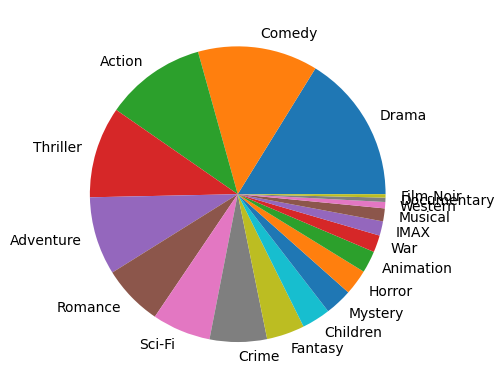

In [20]:
# import plotly.express as px 
# fig = px.pie(genre_distribution, values = genre_distribution.values, names = genre_distribution.keys(), 
#              title='Genre distribution') 
# fig.show()
plt.pie(genre_distribution.values, labels = genre_distribution.keys())
plt.show()

Using Pytorch


In [22]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [23]:
import torch
print(torch.cuda.is_available())


True


Loading movies data...


Loading Data: 100%|██████████| 62423/62423 [00:03<00:00, 17714.70it/s]


Movies data loaded with shape: torch.Size([62423, 20])
Calculating genre distribution...
Genre distribution calculated: tensor([ 2935.,  3595.,  1054.,   195.,  5319.,  1399.,  2925.,  8654.,  4145.,
          353.,  5989.,  7348.,  1874., 25606.,  7719.,  2929., 16870.,  5062.,
         2731.,  5605.])
Plotting genre distribution...
Plot saved to output\genre_distribution.png
Saving genre counts data...
Data saved to output\genre_counts.csv
Saving original movies data...
Data saved to output\original_movies_data.csv
User data processing complete.


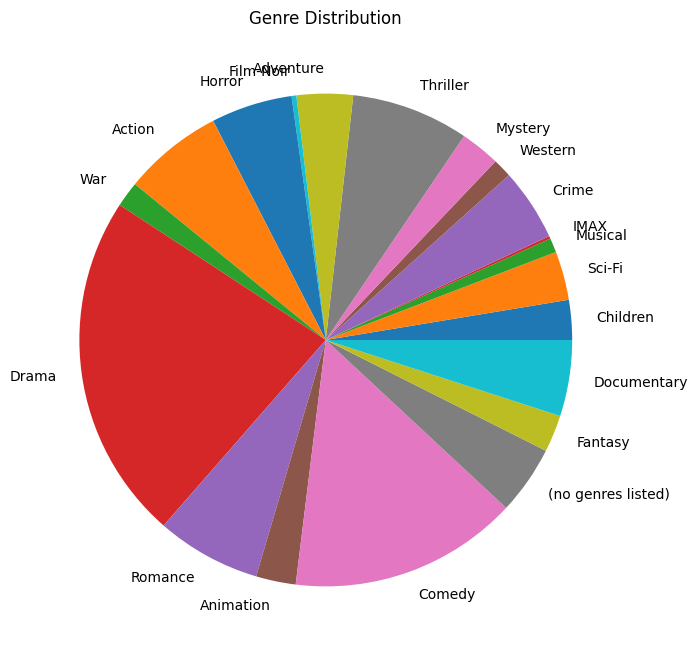

In [24]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from ast import literal_eval
import os

class MovieDataset(Dataset):
    """
    A custom PyTorch Dataset for loading movie data with genres vectorized.
    """
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path, converters={"genres": literal_eval})
        self.genres = set(g for sublist in self.data['genres'] for g in sublist)
        self.genre_to_idx = {genre: i for i, genre in enumerate(self.genres)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        genres = row['genres']
        vector = torch.zeros(len(self.genres), dtype=torch.float32)
        for genre in genres:
            if genre in self.genre_to_idx:
                vector[self.genre_to_idx[genre]] = 1
        return vector

def load_data(file_path):
    dataset = MovieDataset(file_path)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    all_vectors = []
    genre_to_idx = dataset.genre_to_idx  # Capture the genre mapping
    for data in tqdm(loader, desc="Loading Data"):
        all_vectors.append(data)
    return torch.cat(all_vectors, dim=0), genre_to_idx, dataset.data

def save_plot(fig, filename, directory):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    # Save the figure
    path = os.path.join(directory, filename)
    fig.savefig(path)
    print(f"Plot saved to {path}")

def save_data(data, filename, directory):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    # Save the data
    path = os.path.join(directory, filename)
    data.to_csv(path, index=False)
    print(f"Data saved to {path}")

def main():
    output_directory = "output"  # Define the directory to save outputs
    print("Loading movies data...")
    movie_vectors, genre_to_idx, original_data = load_data("data/movies.csv")
    print("Movies data loaded with shape:", movie_vectors.shape)

    print("Calculating genre distribution...")
    genre_counts = torch.sum(movie_vectors, dim=0)
    genre_counts_df = pd.DataFrame({
        'Genre': [genre for genre, _ in sorted(genre_to_idx.items(), key=lambda item: item[1])],
        'Count': genre_counts.numpy()
    })
    print("Genre distribution calculated:", genre_counts)

    print("Plotting genre distribution...")
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pie(genre_counts, labels=genre_counts_df['Genre'])
    plt.title("Genre Distribution")
    save_plot(fig, "genre_distribution.png", output_directory)  # Save the plot to the specified folder

    print("Saving genre counts data...")
    save_data(genre_counts_df, "genre_counts.csv", output_directory)  # Save the genre counts as a CSV

    print("Saving original movies data...")
    save_data(original_data, "original_movies_data.csv", output_directory)  # Save the original movies data

    print("User data processing complete.")

if __name__ == "__main__":
    main()


### Test on entire test data

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [ ]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from ast import literal_eval

In [ ]:
# Load data
user_df = pd.read_csv("data/user_info.csv")
movies_df = pd.read_csv("data/movie_vector.csv")
ratings_test = pd.read_csv("data/testing_data.csv")

# Convert strings to numpy arrays
user_df['user_vector'] = user_df['user_vector'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))
movies_df['movie_vector'] = movies_df['movie_vector'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))


In [ ]:
user_df.columns

Index(['Unnamed: 0', 'userId', 'user_vector', 'avg_rating',
       'num_movies_rated'],
      dtype='object')

In [ ]:
movies_df.columns

Index(['Unnamed: 0', 'movieId', 'title', 'genres', 'movie_vector'], dtype='object')

In [ ]:

# Convert numpy arrays to PyTorch tensors and move to GPU
user_vectors = {user_id: torch.tensor(user_vector, dtype=torch.float32).cuda()
                for user_id, user_vector in zip(user_df['userId'], user_df['user_vector'])}
movie_vectors = {movie_id: torch.tensor(movie_vector, dtype=torch.float32).cuda()
                 for movie_id, movie_vector in zip(movies_df['movieId'], movies_df['movie_vector'])}

# Preallocate memory for algo_predictions
algo_predictions = []

# Define a function for computing predicted ratings
def predict_rating(user_vector, movie_vector):
    # Element-wise multiplication
    elementwise_product = user_vector * movie_vector
    # Compute mean excluding zeros
    non_zero_values = elementwise_product[elementwise_product != 0]
    if non_zero_values.numel() > 0:
        return torch.nanmean(non_zero_values).item()
    else:
        return 0.0

# Predict ratings
total_ratings = len(ratings_test)
with tqdm(total=total_ratings, desc="Processing Ratings") as pbar:
    for _, row in ratings_test.iterrows():
        userId = row['userId']
        movieId = row['movieId']
        og_rating = row['rating']

        try:
            user_vector = user_vectors[userId]
            movie_vector = movie_vectors[movieId]
            predicted_rating = predict_rating(user_vector, movie_vector)
            algo_predictions.append([userId, movieId, user_vector, movie_vector, og_rating, predicted_rating])
        except KeyError:
            print("User or movie not found:", userId, movieId)
        pbar.update(1)

# Create DataFrame from predictions
columns = ['userId', 'movieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating']
algo_predictions_df = pd.DataFrame(algo_predictions, columns=columns)

# Save predictions to CSV if needed
# algo_predictions_df.to_csv("algo_predictions.csv", index=False)

print("Done!")


In [ ]:
# !pip install pyarrow


In [ ]:
# !pip install fastparquet


In [ ]:
import pandas as pd

# Convert tensor objects to lists
algo_predictions_df['user_vector'] = algo_predictions_df['user_vector'].apply(lambda x: x.cpu().numpy().tolist())
algo_predictions_df['movie_vector'] = algo_predictions_df['movie_vector'].apply(lambda x: x.cpu().numpy().tolist())

# Save to Parquet
algo_predictions_df.to_parquet("algo_predictions.parquet", index=False)


In [ ]:
import pandas as pd

# Load the Parquet file into a DataFrame
algo_predictions = pd.read_parquet("algo_predictions.parquet")

# Optionally, print the DataFrame to verify it's loaded correctly
print(algo_predictions.head())


   userId  movieId                                        user_vector  \
0       1      306  [3.5999999046325684, 4.0, 3.8333332538604736, ...   
1       1     1237  [3.5999999046325684, 4.0, 3.8333332538604736, ...   
2       1     1653  [3.5999999046325684, 4.0, 3.8333332538604736, ...   
3       1     2573  [3.5999999046325684, 4.0, 3.8333332538604736, ...   
4       1     2632  [3.5999999046325684, 4.0, 3.8333332538604736, ...   

                                        movie_vector  og_rating  pred_rating  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...        3.5     3.850000  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...        5.0     3.850000  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...        4.0     3.797222  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...        4.0     3.841667  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...        5.0     3.483333  


In [ ]:
rmse = ((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2).mean() ** .5
rmse

0.9358370501966488

In [ ]:
mae = (((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2) ** .5).mean()
mae

0.717817809133086

# KNN MODEL

In [1]:
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
import pandas as pd
from surprise import Dataset, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNBaseline

In [3]:
# Load the movielens-1M dataset
data = Dataset.load_builtin('ml-1m')

In [4]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.20)

In [5]:
import pandas as pd
from surprise import KNNBaseline, accuracy
from surprise.model_selection import train_test_split

def recommendation(algo, trainset, testset):
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    return predictions, rmse, mae

# List of similarity options to iterate over
similarity_options = [
    {'name': 'cosine', 'user_based': False},
    {'name': 'cosine', 'user_based': True},
    {'name': 'msd', 'user_based': False},
    {'name': 'msd', 'user_based': True},
    {'name': 'pearson', 'user_based': False},
    {'name': 'pearson', 'user_based': True},
    {'name': 'pearson_baseline', 'user_based': False},
    {'name': 'pearson_baseline', 'user_based': True}
]

# Create a DataFrame to store all predictions
all_predictions = pd.DataFrame()

for sim_option in similarity_options:
    algo = KNNBaseline(sim_options=sim_option)
    predictions, rmse, mae = recommendation(algo, trainset, testset)
    # Convert predictions to a DataFrame and add metadata
    df = pd.DataFrame(predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
    df['sim_metric'] = sim_option['name']
    df['user_based'] = sim_option['user_based']
    df['rmse'] = rmse
    df['mae'] = mae
    all_predictions = pd.concat([all_predictions, df], ignore_index=True)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8951
MAE:  0.7035
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9020
MAE:  0.7124
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8862
MAE:  0.6955
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8961
MAE:  0.7067
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8902
MAE:  0.6995
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8965
MAE:  0.7066
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8597
MAE:  0.6729
Estimating biases using als...
Computing the pearson_baseline s

In [6]:
all_predictions.to_csv('predictions.csv')

In [7]:
import pandas as pd

# Load the data from CSV
data = pd.read_csv('predictions.csv')

# Assuming the data includes columns named 'sim_metric', 'user_based', 'rmse', 'mae'
# and that 'user_based' is a boolean or similar identifier where True represents user-based and False represents item-based

# Filter and calculate metrics
user_data = data[data['user_based'] == True]  # or whatever identifies user-based
item_data = data[data['user_based'] == False]  # or whatever identifies item-based

# Assuming 'sim_metric' column exists which differentiates the algorithms or settings like 'cosine', 'msd', etc.
x_algo = data['sim_metric'].unique().tolist()

# Gather RMSE and MAE for user-based and item-based configurations
user_rmse = user_data.groupby('sim_metric')['rmse'].mean().reindex(x_algo).tolist()
item_rmse = item_data.groupby('sim_metric')['rmse'].mean().reindex(x_algo).tolist()
user_mae = user_data.groupby('sim_metric')['mae'].mean().reindex(x_algo).tolist()
item_mae = item_data.groupby('sim_metric')['mae'].mean().reindex(x_algo).tolist()

# Output the vectors
print("User RMSE:", user_rmse)
print("Item RMSE:", item_rmse)
print("User MAE:", user_mae)
print("Item MAE:", item_mae)


User RMSE: [0.9020059911752628, 0.8960715220340943, 0.8965495293597362, 0.8698929377244533]
Item RMSE: [0.8950765169945647, 0.886182268560981, 0.8901755416176548, 0.8597153666948463]
User MAE: [0.7123660183417102, 0.7067361010082774, 0.706567343599238, 0.6807512714229784]
Item MAE: [0.7035182873752415, 0.6954836087019243, 0.6994923808186627, 0.6729177311433445]


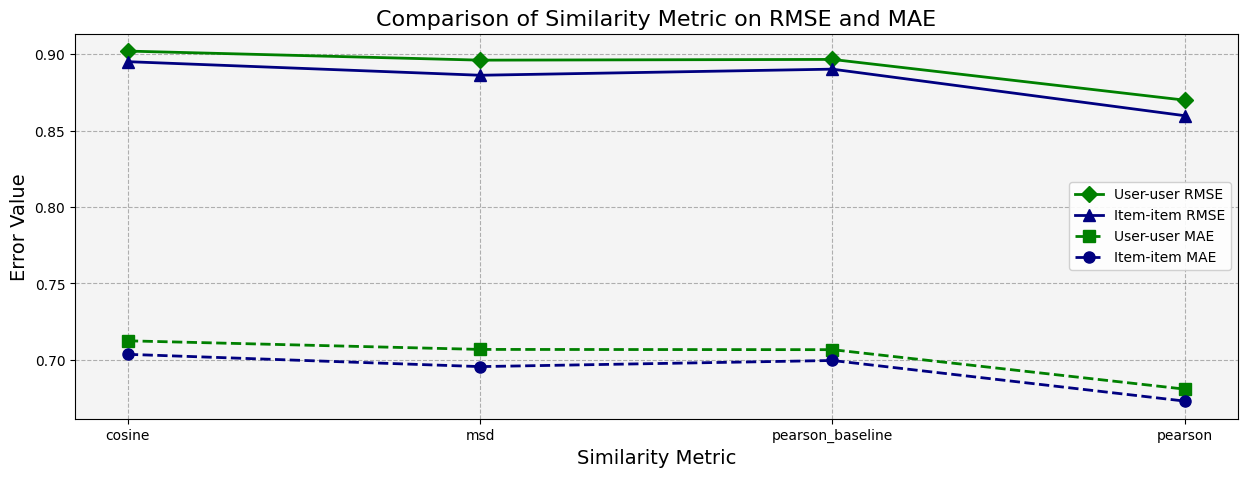

In [8]:
import matplotlib.pyplot as plt

def plot_comparison(x_algo, user_rmse, item_rmse, user_mae, item_mae):
    plt.figure(figsize=(15, 5))
    plt.title('Comparison of Similarity Metric on RMSE and MAE', fontsize=16)
    
    # Setting a background color
    plt.gca().set_facecolor('#f4f4f4')
    plt.grid(True, linestyle='--', color='grey', alpha=0.6)  # Lighter grid
    
    # Plotting
    plt.plot(x_algo, user_rmse, label='User-user RMSE', color='#008000', marker='D', markersize=8, linewidth=2)
    plt.plot(x_algo, item_rmse, label='Item-item RMSE', color='#000080', marker='^', markersize=8, linewidth=2)
    plt.plot(x_algo, user_mae, label='User-user MAE', color='#008000', linestyle='--', marker='s', markersize=8, linewidth=2)
    plt.plot(x_algo, item_mae, label='Item-item MAE', color='#000080', linestyle='--', marker='o', markersize=8, linewidth=2)
    
    # Labels and legend
    plt.xlabel('Similarity Metric', fontsize=14)
    plt.ylabel('Error Value', fontsize=14)
    plt.legend(frameon=True, facecolor='white', framealpha=0.9)
    
    plt.show()

x_algo = ['cosine', 'msd', 'pearson_baseline', 'pearson']
# user_rmse = [0.9024, 0.8967, 0.8697, 0.8968]
# item_rmse = [0.8953, 0.8871, 0.8596, 0.8901]
# user_mae = [0.7134, 0.7080, 0.6811, 0.7072]
# item_mae = [0.7044, 0.6964, 0.6737, 0.7002]

plot_comparison(x_algo, user_rmse, item_rmse, user_mae, item_mae)


# Hybrid Model

In [1]:
import pandas as pd
import numpy as np

In [2]:
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import dump

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [4]:
def convert_traintest_dataframe_forsurprise(training_dataframe, testing_dataframe):
    reader = Reader(rating_scale=(0, 5))
    trainset = Dataset.load_from_df(training_dataframe[['userId', 'movieId', 'rating']], reader)
    testset = Dataset.load_from_df(testing_dataframe[['userId', 'movieId', 'rating']], reader)
    trainset = trainset.construct_trainset(trainset.raw_ratings)
    testset = testset.construct_testset(testset.raw_ratings)
    return trainset, testset

In [5]:
file_path_train = 'data/training_data.csv'
file_path_test = 'data/testing_data.csv'
traindf = pd.read_csv(file_path_train)
testdf = pd.read_csv(file_path_test)
trainset, testset = convert_traintest_dataframe_forsurprise(traindf, testdf)

In [6]:
testdf.head()

,userId,movieId,rating,timestamp,genres,tag
0,1,306,3.5,1147868817,['Drama'],[]
1,1,1237,5.0,1147868839,['Drama'],[]
2,1,1653,4.0,1147868097,"['Drama', 'Sci-Fi', 'Thriller']",[]
3,1,2573,4.0,1147878923,"['Drama', 'Musical']",[]
4,1,2632,5.0,1147878248,"['Adventure', 'Drama', 'Mystery']",[]


### CF and Latent Factor models:

In [7]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import BaselineOnly, NormalPredictor
from surprise import accuracy
from surprise.dump import dump

import numpy as np

def precision_at_k(predictions, k=10, threshold=3.0):
    user_est_true = {}
    for uid, _, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((est, true_r))
    
    precisions = {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

    return precisions

data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.15, random_state=42)

algorithms = [
    KNNBasic(),
    KNNWithMeans(),
    KNNWithZScore(),
    KNNBaseline(),
    SVD(),
    SVDpp(),
    NMF(),
    SlopeOne(),
    CoClustering(),
    BaselineOnly(),
    NormalPredictor()
]

for algo in algorithms:
    print(f"Evaluating {algo.__class__.__name__}...")
    algo.fit(trainset)
    predictions = algo.test(testset)
    file_name = f'{algo.__class__.__name__}_model'
    dump(file_name, algo=algo, predictions=predictions)
    
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    precisions = precision_at_k(predictions, k=5, threshold=3)
    precision = np.mean(list(precisions.values()))
    print(f"RMSE: {rmse}, MAE: {mae}, Precision@5: {precision:.3f}")
    print("")

print("Evaluation complete!")


Evaluating KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9733
MAE:  0.7672
RMSE: 0.9733386600536164, MAE: 0.7671741094078294, Precision@5: 0.914

Evaluating KNNWithMeans...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9475
MAE:  0.7459
RMSE: 0.9474597748929636, MAE: 0.7459450937166805, Precision@5: 0.923

Evaluating KNNWithZScore...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9490
MAE:  0.7448
RMSE: 0.9490248330405988, MAE: 0.7448278177214052, Precision@5: 0.920

Evaluating KNNBaseline...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9254
MAE:  0.7289
RMSE: 0.9253509215389562, MAE: 0.7288614583810952, Precision@5: 0.918

Evaluating SVD...
RMSE: 0.9293
MAE:  0.7295
RMSE: 0.9293100784145555, MAE: 0.7294729516105539, Precision@5: 0.917

Evaluating SVDpp...
RMSE: 0.9170
MAE:  0.7172
RMSE: 0.9169706548278865

In [8]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVDpp, KNNBaseline, dump, accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import dask.dataframe as dd

def load_data_dask(file_path, columns=None, fraction=1.0):
    data = dd.read_csv(file_path)
    if columns is not None:
        data = data[columns]
    if fraction < 1.0:
        data = data.sample(frac=fraction)
    data = data.compute()
    print(f"Data loaded from {file_path} with columns {columns}, fraction: {fraction}")
    return data

def convert_dataframe_forsurprise(df):
    reader = Reader(rating_scale=(0, 5))
    return Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Load and process training data
traindf = load_data_dask('data/training_data.csv', ['userId', 'movieId', 'rating'], fraction=0.01)
movies = load_data_dask("data/movies.csv", ['movieId', 'title', 'genres'], fraction=0.1)

# Prepare data for Surprise
train_data = convert_dataframe_forsurprise(traindf)
trainset = train_data.build_full_trainset()

# Train SVDpp and KNNBaseline
svdpp = SVDpp()
svdpp.fit(trainset)
sim_options = {'name': 'cosine', 'user_based': False}
knnbaseline = KNNBaseline(sim_options=sim_options)
knnbaseline.fit(trainset)

def get_user_recommendations(user_id):
    unrated_movies = movies[~movies['movieId'].isin(traindf[traindf['userId'] == user_id]['movieId'].unique())]
    predictions = []

    for idx, row in unrated_movies.iterrows():
        movie_id = row['movieId']
        svdpp_est = svdpp.predict(user_id, movie_id).est
        knn_est = knnbaseline.predict(user_id, movie_id).est
        predictions.append((movie_id, svdpp_est, 'SVDpp'))
        predictions.append((movie_id, knn_est, 'KNNBaseline'))

    # Create DataFrame from predictions
    recommendations_df = pd.DataFrame(predictions, columns=['movieId', 'predicted_rating', 'model'])
    recommendations_df = recommendations_df.merge(movies, on='movieId')

    # Sort by predicted rating and get top 10
    top_recommendations = recommendations_df.sort_values(by='predicted_rating', ascending=False).head(10)
    return top_recommendations



Data loaded from data/training_data.csv with columns ['userId', 'movieId', 'rating'], fraction: 0.01
Data loaded from data/movies.csv with columns ['movieId', 'title', 'genres'], fraction: 0.1
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [9]:
# Fetch recommendations for a user
user_id = 60
top_recommendations = get_user_recommendations(user_id)


In [10]:
print(f"Top 10 Recommendations for User ID {user_id}:")


Top 10 Recommendations for User ID 60:


In [11]:
print(top_recommendations[['movieId', 'title', 'genres', 'predicted_rating', 'model']])


       movieId                                              title  \
4384       750  Dr. Strangelove or: How I Learned to Stop Worr...   
4385       750  Dr. Strangelove or: How I Learned to Stop Worr...   
997      44555  Lives of Others, The (Das leben der Anderen) (...   
3496    179135                              Blue Planet II (2017)   
3154       905                       It Happened One Night (1934)   
8392      3134         Grand Illusion (La grande illusion) (1937)   
1903       745             Wallace & Gromit: A Close Shave (1995)   
12435      910                            Some Like It Hot (1959)   
7521      1233                       Boot, Das (Boat, The) (1981)   
1902       745             Wallace & Gromit: A Close Shave (1995)   

                                    genres  predicted_rating        model  
4384                     ['Comedy', 'War']          4.130064        SVDpp  
4385                     ['Comedy', 'War']          4.061661  KNNBaseline  
997       ['

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the movie data from a CSV file
movies = pd.read_csv("data/movies.csv")

# Define genre to index mappings (assuming these are used elsewhere in your code)
genre_to_idx = {
    'Adventure': 0, 'Animation': 1, 'Children': 2, 'Comedy': 3, 'Fantasy': 4,
    'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9,
    'Horror': 10, 'Mystery': 11, 'Sci-Fi': 12, 'War': 13, 'Musical': 14,
    'Documentary': 15, 'IMAX': 16, 'Western': 17, 'Film-Noir': 18,
    '(no genres listed)': 19
}
idx_to_genre = {v: k for k, v in genre_to_idx.items()}  # Reverse mapping

# Ensure the 'tagline', 'overview', and 'genres' columns are present and handle if not
if 'tagline' not in movies.columns:
    print("Warning: 'tagline' column not found. Using an empty string as default.")
    movies['tagline'] = ''
else:
    movies['tagline'] = movies['tagline'].fillna('')

if 'overview' not in movies.columns:
    print("Warning: 'overview' column not found. Using an empty string as default.")
    movies['overview'] = ''
else:
    movies['overview'] = movies['overview'].fillna('')

if 'genres' not in movies.columns:
    print("Warning: 'genres' column not found. Using an empty string as default.")
    movies['genres'] = ''
else:
    movies['genres'] = movies['genres'].fillna('')

# Combine fields to create a description genre column
movies['description_genre'] = movies['overview'] + movies['tagline'] + 2 * movies['genres']

movies.to_csv("data/movies_tmdb.csv")

In [13]:
genre_to_idx = {'Adventure': 0,
 'Animation': 1,
 'Children': 2,
 'Comedy': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'Mystery': 11,
 'Sci-Fi': 12,
 'War': 13,
 'Musical': 14,
 'Documentary': 15,
 'IMAX': 16,
 'Western': 17,
 'Film-Noir': 18,
 '(no genres listed)': 19}
idx_to_genre = {0: 'Adventure',
 1: 'Animation',
 2: 'Children',
 3: 'Comedy',
 4: 'Fantasy',
 5: 'Romance',
 6: 'Drama',
 7: 'Action',
 8: 'Crime',
 9: 'Thriller',
 10: 'Horror',
 11: 'Mystery',
 12: 'Sci-Fi',
 13: 'War',
 14: 'Musical',
 15: 'Documentary',
 16: 'IMAX',
 17: 'Western',
 18: 'Film-Noir',
 19: '(no genres listed)'}

In [14]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVDpp, KNNBaseline, accuracy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import dask.dataframe as dd

# Load and process data with improved logging and efficiency
def load_data_dask(file_path, columns=None, fraction=1.0):
    data = dd.read_csv(file_path)
    if columns:
        data = data[columns]
    if fraction < 1.0:
        data = data.sample(frac=fraction)
    data = data.compute()
    return data
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, KNNBaseline, SVDpp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import dask.dataframe as dd

# Content-based recommendation using precomputed cosine similarity
def get_recommendations_new(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    return movies_tmdb['id'].iloc[[i[0] for i in sim_scores]]

# More efficient genre-based popularity function
def genre_based_popularity(genre):
    mask = movies_tmdb['genres'].str.contains(genre, na=False)
    return movies_tmdb[mask].nlargest(10, 'popularity')['id'].tolist()

# Simplified top genre extraction
def user_top_genre(userId):
    user_vec = np.array(user_info.loc[user_info['userId'] == userId, 'user_vector'].iloc[0].strip('[]').split(), dtype=float)
    top_indices = np.argsort(user_vec)[-3:]
    return [idx_to_genre[i] for i in top_indices]

def get_title(x):
    mid = x['movieId']
    return movies['title'][movies['id'] == mid].values



In [42]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, KNNBaseline, SVDpp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import dask.dataframe as dd


# Define necessary data structures and initialize models
idx_to_genre = {v: k for k, v in genre_to_idx.items()}
movies_tmdb = pd.read_csv("data/tmdb_5000_movies.csv")
user_info = pd.read_csv('data/user_info.csv')
traindf = load_data_dask('data/training_data.csv', ['userId', 'movieId', 'rating'], 0.095)
testdf = load_data_dask('data/testing_data.csv', ['userId', 'movieId', 'rating'], 0.095)

# Setup DataFrame for movies
movies = movies_tmdb.copy()
movies['description_genre'] = movies['overview'].fillna('') + ' ' + movies['tagline'].fillna('') + ' ' + movies['genres'].fillna('')
cv = CountVectorizer()
count_matrix = cv.fit_transform(movies['description_genre'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
indices = pd.Series(movies.index, index=movies['title'])

# Initialize ML models
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(traindf[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine', 'user_based': False}
knnbaseline_algo = KNNBaseline(sim_options=sim_options)
knnbaseline_algo.fit(trainset)
svdpp_algo = SVDpp()
svdpp_algo.fit(trainset)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [48]:
def hybrid_recommendations(userId):
    print("Starting refined hybrid recommendations...")
    
    user_movies = testdf[testdf['userId'] == userId].copy()
    user_movies['est'] = user_movies['movieId'].apply(
        lambda x: 0.5 * knnbaseline_algo.predict(userId, x).est + 0.5 * svdpp_algo.predict(userId, x).est
    )
    user_movies = user_movies.sort_values(by='est', ascending=False).head(5)
    user_movies['Model'] = 'SVD + CF'
    user_movies['movieName'] = user_movies['movieId'].apply(lambda x: movies.loc[movies['id'] == x, 'title'].values[0] if not movies[movies['id'] == x].empty else 'Unknown')
    recommend_list = user_movies[['movieId', 'movieName', 'est', 'Model']]
    print("Initial CF Recommendations:", recommend_list)

    # Content-based recommendations
    movie_list = recommend_list['movieId'].values.tolist()
    content_based_list = pd.DataFrame()
    for movie_id in movie_list:
        movie_title_series = movies[movies['id'] == movie_id]['title']
        if not movie_title_series.empty:
            movie_title = movie_title_series.values[0]
            sim_movies = get_recommendations_new(movie_title)
            for sim_movie_id in sim_movies:
                pred_rating = 0.5 * knnbaseline_algo.predict(userId, sim_movie_id).est + 0.5 * svdpp_algo.predict(userId, sim_movie_id).est
                content_based_list = pd.concat([content_based_list, pd.DataFrame({'movieId': [sim_movie_id], 'est': [pred_rating], 'Model': ['Movie similarity'], 'movieName': [movies.loc[movies['id'] == sim_movie_id, 'title'].values[0] if not movies[movies['id'] == sim_movie_id].empty else 'Unknown']})], ignore_index=True)

    if not content_based_list.empty:
        content_based_list = content_based_list.sort_values(by='est', ascending=False).head(5)
        recommend_list = pd.concat([recommend_list, content_based_list], ignore_index=True)
    
    # Popularity-based recommendations
    top_genre_list = user_top_genre(userId)
    popularity_list = pd.DataFrame()
    for top_genre in top_genre_list:
        popular_movies = genre_based_popularity(top_genre)
        for movie_id in popular_movies:
            pred_rating = 0.4 * knnbaseline_algo.predict(userId, movie_id).est + 0.6 * svdpp_algo.predict(userId, movie_id).est
            popularity_list = pd.concat([popularity_list, pd.DataFrame({'movieId': [movie_id], 'est': [pred_rating], 'Model': ['Popularity'], 'movieName': [movies.loc[movies['id'] == movie_id, 'title'].values[0] if not movies[movies['id'] == movie_id].empty else 'Unknown']})], ignore_index=True)
    
    if not popularity_list.empty:
        popularity_list = popularity_list.sort_values(by='est', ascending=False).head(5)
        recommend_list = pd.concat([recommend_list, popularity_list], ignore_index=True)

    recommend_list = recommend_list.drop_duplicates(subset=['movieId'])
    train_movie_list = traindf[traindf['userId'] == userId]['movieId'].values.tolist()
    recommend_list = recommend_list[~recommend_list['movieId'].isin(train_movie_list)]
    recommend_list = recommend_list.sort_values(by='est', ascending=False)
    print("Final Refined Recommendations:", recommend_list)
    return recommend_list




In [49]:
user_id = 60
results = hybrid_recommendations(user_id)

Starting refined hybrid recommendations...
Initial CF Recommendations:       movieId movieName       est     Model
1555     2288    Closer  3.434708  SVD + CF
1552     2077   Unknown  2.735500  SVD + CF
Final Refined Recommendations:     movieId            movieName       est             Model
2      1844           Entrapment  3.579967  Movie similarity
3       508        Love Actually  3.534001  Movie similarity
0      2288               Closer  3.434708          SVD + CF
7       272        Batman Begins  3.415675        Popularity
4    206296  The Last Five Years  3.389639  Movie similarity
5      9095          Mary Reilly  3.389639  Movie similarity
6    239571       The Best of Me  3.389639  Movie similarity
8    211672              Minions  3.380685        Popularity
9    177572           Big Hero 6  3.380685        Popularity
10    20352        Despicable Me  3.380685        Popularity
11    62177                Brave  3.380685        Popularity
1      2077              Unknown  

In [50]:
results

,movieId,movieName,est,Model
2,1844,Entrapment,3.579967,Movie similarity
3,508,Love Actually,3.534001,Movie similarity
0,2288,Closer,3.434708,SVD + CF
7,272,Batman Begins,3.415675,Popularity
4,206296,The Last Five Years,3.389639,Movie similarity
5,9095,Mary Reilly,3.389639,Movie similarity
6,239571,The Best of Me,3.389639,Movie similarity
8,211672,Minions,3.380685,Popularity
9,177572,Big Hero 6,3.380685,Popularity
10,20352,Despicable Me,3.380685,Popularity


In [51]:
user_id = 6
results_user6 = hybrid_recommendations(user_id)


Starting refined hybrid recommendations...
Initial CF Recommendations: Empty DataFrame
Columns: [movieId, movieName, est, Model]
Index: []
Final Refined Recommendations:    movieId                                   movieName       est       Model
0       58  Pirates of the Caribbean: Dead Man's Chest  4.280147  Popularity
1     8966                                    Twilight  3.924213  Popularity
2   157336                                Interstellar  3.617149  Popularity
3   177572                                  Big Hero 6  3.614187  Popularity
4    19995                                      Avatar  3.614187  Popularity


In [52]:
results_user6

,movieId,movieName,est,Model
0,58,Pirates of the Caribbean: Dead Man's Chest,4.280147,Popularity
1,8966,Twilight,3.924213,Popularity
2,157336,Interstellar,3.617149,Popularity
3,177572,Big Hero 6,3.614187,Popularity
4,19995,Avatar,3.614187,Popularity
